# Fit BAO peak from input correlation function

In [1]:
import numpy as np

from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams.update({'font.size': 14})

from pycorr import TwoPointCorrelationFunction, TwoPointEstimator, NaturalTwoPointEstimator, project_to_multipoles, project_to_wp, utils, setup_logging
from cosmoprimo import *

from densitysplit import catalog_data, density_split
from bin.density_split_mocks_functions import split_density, compute_densitySplit_CCF
from densitysplit.bao_model import *
from densitysplit.split_fit import *
from densitysplit.utils import *
from densitysplit.corr_func import *

# To activate logging
setup_logging()

## Data and output directories

In [2]:
data_dir = '/feynman/work/dphp/mp270220/data/'
output_dir = '/feynman/work/dphp/mp270220/outputs/'

## Get data

In [3]:
#catalog_name = 'AbacusSummit_1Gpc_z1.175'
#bias = 1.8

catalog_name = 'AbacusSummit_2Gpc_z1.175'
#bias = 3.

#catalog_name = 'AbacusSummit_2Gpc_z0.800'
#catalog_name = 'mock'

catalog = catalog_data.Data.load(data_dir+catalog_name+'.npy')
catalog.shift_boxcenter(-catalog.offset)

In [4]:
z = catalog.redshift

# Abacus summit base cosmology
cosmo_abacus = fiducial.AbacusSummitBase()
bg = cosmo_abacus.get_background()
f = bg.Omega_m(z)**0.55

## Load correlation function poles

In [5]:
ells = [0]
nells = len(ells)

### Density split

In [6]:
nsplits = 3
nmocks = 1000
abacus_split_results = np.load(output_dir+catalog.name+'_densitySplit_rh_CCFs_cellsize10_randomsize4_RSD.npy', allow_pickle=True)
mocks_split_results = np.load(output_dir+'AbacusSummit_1Gpc_z1.175'+'_1000_mocks_densitySplit_rh_CCF_cellsize10_randomsize4_RSD_all.npy', allow_pickle=True)

In [7]:
_, split_cov = get_split_poles(mocks_split_results, ells, nsplits)
split_xiell = [abacus_split_results[split].get_corr(ells=ells, return_sep=False) for split in range(nsplits)]
split_cov /= 8

In [8]:
s, _ = abacus_split_results[0].get_corr(ells=ells, return_sep=True)

### 2PCF

In [9]:
nsplits = 1
abacus_result = TwoPointCorrelationFunction.load(output_dir+catalog.name+'_2PCF.npy')
mocks_results = np.load(output_dir+'AbacusSummit_1Gpc_z1.175'+'_1000_mocks_2PCF.npy', allow_pickle=True)
f=0

_, cov = get_poles(mocks_results, ells)

s, xiell = abacus_result.get_corr(ells=ells, return_sep=True)

[000002.28]  05-30 22:56  TwoPointEstimator            INFO     Loading /feynman/work/dphp/mp270220/outputs/AbacusSummit_2Gpc_z1.175_2PCF.npy.


In [10]:
cov /= 8.

In [11]:
# Remove small scales (linear model not valid at small scales)
s_lower_limit = 50 # Mpc/h

ns = len(s[s > s_lower_limit])
# Hartlap correction
hartlap = (nmocks-1)/(nmocks-ns*nsplits*nells-2)
split_cov *= hartlap
cov *= hartlap

## Set power spectrum model

In [12]:
bao_model = BAOModel(sep=s, k=np.logspace(-3,2,1000), ells=ells, redshift=z, cosmology=cosmo_abacus, iso=True, nsplits=1)

bao_model.set_params(f=f, sigma_s=0)

In [13]:
bao_model.model_params

{'f': 0,
 'sigma_s': 0,
 'alpha_iso': 1.0,
 'sigma_iso': 5,
 'b_DS1': 2.0,
 'bb0_0_DS1': 0,
 'bb1_0_DS1': 0,
 'bb2_0_DS1': 0}

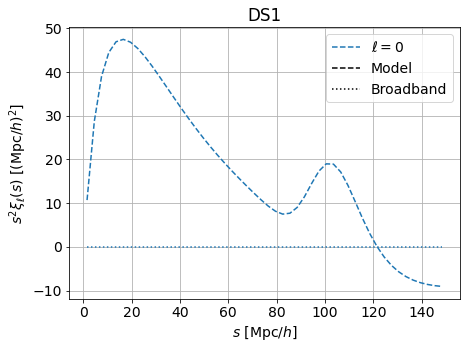

In [14]:
fig, axes = plt.subplots(1, 1, figsize=(7, 5), sharey = False)

bao_model.plot_split_model(fig=fig, axes=axes, show_broadband=True)

In [15]:
ds_fit = DensitySplitFit(sep=s, k=np.logspace(-3,2,1000), ells=ells, xiell=xiell, cov=cov, 
                         xi_model=bao_model, model_params=bao_model.model_params, model_params_labels=bao_model.model_params_labels, 
                         nsplits=1)

In [16]:
import time

/feynman/home/dphp/mp270220/densitysplit/densitysplit/split_fit.py:88: IMinuitWarning: errordef not set, using 1 (appropriate for least-squares)
  m.migrad()


Optimal parameters:
{'b_DS1': 1.7834699350325756, 'alpha_iso': 1.0005219779207417, 'sigma_iso': 3.564369482771586, 'bb0_0_DS1': 1.8813692208794115, 'bb1_0_DS1': -0.029956216331144328, 'bb2_0_DS1': 0.00013387988676226344}

Covariance matrix:
[[ 4.22593091e-03  1.79021311e-05  3.02197793e-02 -2.06950500e-01
   2.54770259e-03 -6.82743072e-06]
 [ 1.79021311e-05  1.04923258e-05  2.08938071e-04 -1.22748077e-04
   1.10671730e-05 -5.88560820e-08]
 [ 3.02197793e-02  2.08938071e-04  4.15032154e-01 -1.45650033e+00
   1.75939863e-02 -4.39149643e-05]
 [-2.06950500e-01 -1.22748077e-04 -1.45650033e+00  2.05772960e+01
  -3.87095619e-01  1.68955060e-03]
 [ 2.54770259e-03  1.10671730e-05  1.75939863e-02 -3.87095619e-01
   8.67085834e-03 -4.24892793e-05]
 [-6.82743072e-06 -5.88560820e-08 -4.39149643e-05  1.68955060e-03
  -4.24892793e-05  2.27482741e-07]]

Sigmas:
[6.50071604e-02 3.23918598e-03 6.44229892e-01 4.53622046e+00
 9.31174438e-02 4.76951508e-04]
Execution time:  94.57392692565918


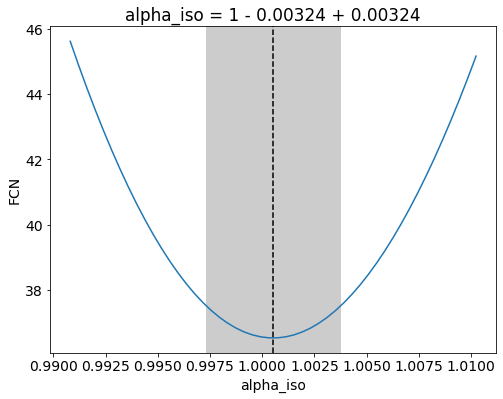

In [17]:
broadband_coeffs = np.tile([0., 0., 0.], nells)
#params_init = {'b_DS1': 2., 'b_DS2': 2., 'b_DS3': 2.5, 'alpha_par': 1., 'alpha_perp': 1., 'sigma_par': 5., 'sigma_perp': 5.,}
params_init = {'b_DS1': 2, 'alpha_iso': 1., 'sigma_iso': 5.}

for split in range(bao_model.nsplits):
    for ill in range(bao_model.nells):
        for k in range(3):
            params_init.update({'bb{}_{}_DS{}'.format(k, ill, split+1): 0})

t1 = time.time()
ds_fit.fit(fit_params_init=params_init, s_lower_limit=50, fit_method='iminuit', mnprofile=True, profile_param='alpha_iso') #, mncontour=True, contour_params=['alpha_par', 'alpha_perp'])
t2 = time.time()
print('Execution time: ', t2-t1)

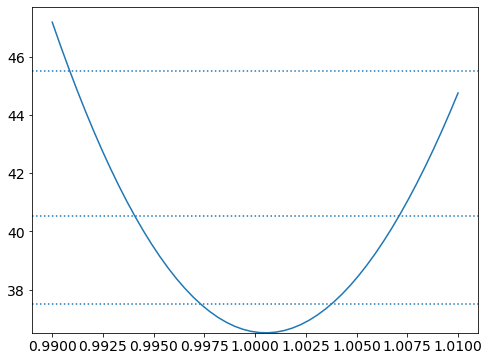

In [18]:
free_params_init = copy.deepcopy(params_init)
free_params_init.pop('alpha_iso')

ds_fit.plot_likelihood(param_name='alpha_iso', param_values=np.linspace(0.99, 1.01, 50), free_params_init=free_params_init)

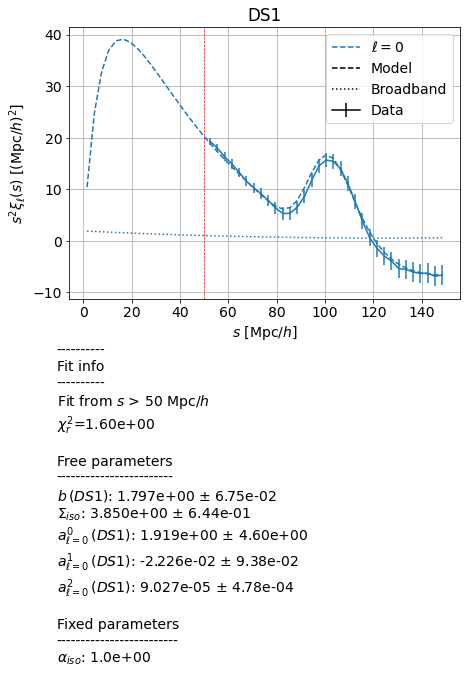

In [19]:
fig, axes = plt.subplots(1, 1, figsize=(7, 5), sharey = False)

ds_fit.plot_split_model(fig=fig, axes=axes, show_broadband=True, show_info=True)